![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRjFm003pSAOtHmnUm7e--Xquwo90Hp5-U_3wSZrkChGz4tQYWZ)
# Introduction to Machine Learning
## Innopolis University 
### Week 12: GAN

Plan:

1. VAE recap
1. Cross-entropy
2. GAN


## Variational autoencoders

1. Why do we need them?
2. How training is different from that of usual autoencoder?
3. Describe the process of generation


Intuition 1.

![alt text](https://miro.medium.com/max/2339/1*83S0T8IEJyudR_I5rI9now@2x.png)

Intuition 2.

![alt text](https://miro.medium.com/max/2339/1*9ouOKh2w-b3NNOVx4Mw9bg@2x.png)

## Binary Cross-entropy
In code:

$loss(y, \hat{y})$ 

One sample:

$-y \log(\hat{y}) - (1-y) \log(1-\hat{y}) $

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlSmbw8peOe5wUb3DnrCQIcy7Fa3CA1EyxRGTwXSUVe3lAvSY2Sw&s)

Average:

$\frac{1}{N}\sum_{i=1}^{N} (-y_i \log(\hat{y_i}) - (1-y_i) \log(1-\hat{y_i})) $



## GAN
GAN architecture:

![alt text](https://skymind.ai/images/wiki/GANs.png)

In [0]:
import torch
# Device configuration
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Run on", device_name)
device = torch.device(device_name)

Run on cuda


## Network in pytorch

Your task today will be to train GAN.

In [0]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
%matplotlib inline

os.makedirs("images", exist_ok=True)

batch_size=64
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
img_size=28
channels=1
sample_interval=400

img_shape = (channels, img_size, img_size)

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

Discriminator solves binary classification problem. So we will take a binary cross-entropy loss function.

In [0]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [0]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [0]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor 

### Training 

Here you should write code to train generator and discriminator models. If you forgot, how to make a backpropogation and optimizations steps, open [autoencoders lab](https://colab.research.google.com/drive/10GwXDsN9wKQjmIeA3XtHE3KgK2NUqhRg#scrollTo=gMH6sPuILQLk).

#### Generator

1.   Generate random noise
2.   Generate fake images
3.   Calculate generator loss
4.   Calculate gradients and update parameters

#### Discriminator

1.   Calculate loss for fake images
2.   Calculate loss for real images
3.   Caclulate an average of above two
4.   Calculate gradients and update parameters


2019-10-24 11:51:00.648236
Epoch 0


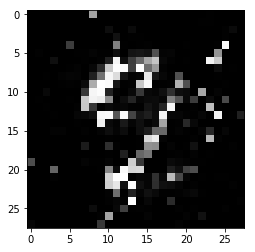

2019-10-24 11:51:21.683125
Epoch 1


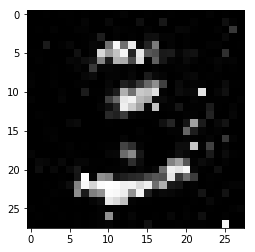

2019-10-24 11:51:42.764690
Epoch 2


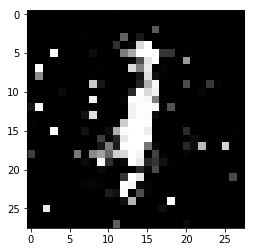

2019-10-24 11:52:03.760371
Epoch 3


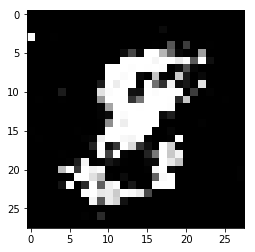

KeyboardInterrupt: ignored

In [0]:
import datetime
# ----------
#  Training
# ----------

tiny_n_epochs = 5
n_epochs=200

for epoch in range(n_epochs):   
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        ### YOUR CODE HERE ###
        optimizer_G.zero_grad()

        # Sample noise as generator input
        #z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        z = Variable(torch.randn((imgs.shape[0], latent_dim)).cuda())
        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        ### YOUR CODE HERE ###
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

    gen_imgs = generator(z)

    output_img = gen_imgs[0].cpu()
    out = output_img.data.numpy()
    print(datetime.datetime.now())
    print("Epoch %d" % epoch)
    plt.imshow(out[0],cmap="gray")
    plt.show()

            

Visualize generated image.

In [0]:
### YOUR CODE HERE ###
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

gen_imgs = generator(z)

output_img = gen_imgs[0].cpu()
out = output_img.data.numpy()
print("Output image")
plt.imshow(out[0],cmap="gray")
plt.show()

Add a visualisation to the train process. Visualize 1 image in every epoch.

Train for 200 epochs.

# References

https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

https://skymind.ai/wiki/generative-adversarial-network-gan

https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
